In [115]:
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.metrics as skm
from sklearn.base import clone
from sklearn.preprocessing import scale
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from pandas.tools.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
start_date = pd.to_datetime('2014-07-01', format='%Y-%m-%d')

Subtract 30 days from the scrape time to get the start time for active users. Note: we must use a datetime.timedelta object or we will end up subtracting the wrong units (microseconds).

In [3]:
start_date = start_date - datetime.timedelta(30,0,0)
start_date

Timestamp('2014-06-01 00:00:00')

Load data and check that it loaded correctly.

In [4]:
df = pd.read_csv('data/churn.csv')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Data hygiene

In [5]:
df.last_trip_date = pd.to_datetime(df.last_trip_date, format = '%Y-%m-%d')
df.signup_date = pd.to_datetime(df.signup_date, format = '%Y-%m-%d')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


Check all features are the correct types.

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [7]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [8]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

phone is already categorical, so we can add another factor level to handle missing values. Be careful not to over clean data, because you can use useful predictive information. Note: we added this step based on analysis of missing values below.

In [9]:
df.phone = df.phone.fillna('no_phone')

Convert columns with categorical data into categorical type

In [10]:
df.city = df.city.astype("category")
df.phone = df.phone.astype('category')

Check conversion

In [11]:
pd.crosstab(df.phone, df.city)

city,Astapor,King's Landing,Winterfell
phone,,,
Android,5244,2498,7280
iPhone,11169,7568,15845
no_phone,121,64,211


### Create a label/target/outcome

Add churn indicator. Considered to churn if have not taken a trip in the last 30 days. In practice, you will often have to figure out how to generate a reasonable label to train your dataset. Is the cutoff of 30 days reasonable? You may want to test this... Sometimes, the correct label is even less obvious; your ability to make a sensible (and defensible) decision in these cases is important.

In addition, do you agree with how the data was aggregated? It would be helpful to look at lagged usage for the previous week, the week before that, and so on. Also, checking changes in average rating over time could be helpful.

In [12]:
df['is_active'] = (start_date < df.last_trip_date)

In [13]:
df.is_active.value_counts(dropna=False)

False    31690
True     18310
Name: is_active, dtype: int64

Create a churned indicator to use as a training label. However, it may make more sense to use `is_active` because we can more easily focus on what factors lead to retention. 

In [14]:
df['b_churned'] = -df.is_active


In [15]:
df.b_churned.value_counts(dropna=False)

True     31690
False    18310
Name: b_churned, dtype: int64

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [17]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,is_active,b_churned
avg_dist,1.000000,0.080540,0.034509,-0.081491,-0.104414,-0.136329,0.032310,0.101652,-0.090279,0.090279
avg_rating_by_driver,0.080540,1.000000,0.123175,0.010597,0.020103,-0.039115,0.009343,0.020442,-0.025635,0.025635
avg_rating_of_driver,0.034509,0.123175,1.000000,-0.026189,-0.003899,-0.011302,-0.002086,0.014630,-0.010834,0.010834
avg_surge,-0.081491,0.010597,-0.026189,1.000000,0.793582,-0.001841,-0.078791,-0.110071,-0.003567,0.003567
surge_pct,-0.104414,0.020103,-0.003899,0.793582,1.000000,0.005720,-0.106861,-0.144918,0.010612,-0.010612
trips_in_first_30_days,-0.136329,-0.039115,-0.011302,-0.001841,0.005720,1.000000,0.112210,0.050388,0.214728,-0.214728
luxury_car_user,0.032310,0.009343,-0.002086,-0.078791,-0.106861,0.112210,1.000000,0.035998,0.210259,-0.210259
weekday_pct,0.101652,0.020442,0.014630,-0.110071,-0.144918,0.050388,0.035998,1.000000,0.026413,-0.026413
is_active,-0.090279,-0.025635,-0.010834,-0.003567,0.010612,0.214728,0.210259,0.026413,1.000000,-1.000000
b_churned,0.090279,0.025635,0.010834,0.003567,-0.010612,-0.214728,-0.210259,-0.026413,-1.000000,1.000000


### Checking dates

There are often problems with dates, so let's perform some simple checks as part of EDA

In [18]:
np.any(df.last_trip_date < df.signup_date)

False

See what distribution of signup dates looks like

In [19]:
df['signup_year'] = df.signup_date.apply(lambda x: x.year)
df['signup_month'] = df.signup_date.apply(lambda x: x.month)
pd.crosstab(df.signup_month, df.signup_year)


signup_year,2014
signup_month,
1,50000


This means we don't need to worry about any customers who joined in the last 30 days.

In [20]:
df.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

So all of our signup data comes from January. This could affect customer type and retention if there is a selection effect based on `signup_date.

In [21]:
df['last_year'] = df.last_trip_date.apply(lambda x: x.year)
df['last_month'] = df.last_trip_date.apply(lambda x: x.month)
pd.crosstab(df.last_month, df.last_year)

last_year,2014
last_month,
1,10147
2,4308
3,4568
4,4588
5,7585
6,18256
7,548


Let's take a look at June to see what is going on day by day

In [22]:
dftmp = df[df.last_month == 6]
dftmp['last_day'] = dftmp.last_trip_date.apply(lambda x: x.day)
dftmp.last_day.value_counts()


/home/neelima/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


29    2036
28    1679
30    1408
27    1120
22    1024
21     869
26     793
14     665
15     647
20     612
25     603
23     546
7      534
8      527
1      494
19     455
24     440
13     438
18     400
12     351
6      314
16     310
11     297
17     296
5      262
9      262
10     244
4      240
2      208
3      182
Name: last_day, dtype: int64

In [23]:
df.groupby(['is_active', 'last_month']).mean()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
is_active last_month                                                         
False     1           6.816549              4.806602              4.633324   
          2           6.038006              4.778979              4.585495   
          3           5.882500              4.778203              4.591581   
          4           6.038993              4.773951              4.599419   
          5           5.788456              4.780513              4.602883   
          6           4.959534              4.749797              4.576047   
True      6           5.147640              4.763216              4.592054   
          7           4.189927              4.760036              4.633271   

                      avg_surge  surge_pct  trips_in_first_30_days  \
is_active last_month                                                 
False     1            1.078925   8.926274                1.710161   
          2            1.089396   9.338649                2.112813   
          3            1.085274   8.715740                1.290061   
          4            1.060728   7.656168                1.378814   
          5            1.065413   8.519684                1.722347   
          6            1.077105  10.065789                1.702429   
True      6            1.073605   9.094961                3.291071   
          7            1.077464  10.204380                5.246350   

                      luxury_car_user  weekday_pct  b_churned  signup_year  \
is_active last_month                                                         
False     1                  0.287868    59.999704        1.0       2014.0   
          2                  0.305942    61.031848        1.0       2014.0   
          3                  0.318739    57.635924        1.0       2014.0   
          4                  0.318221    62.013622        1.0       2014.0   
          5                  0.290310    62.281239        1.0       2014.0   
          6                  0.279352    30.789474        1.0       2014.0   
True      6                  0.511316    61.948897        0.0       2014.0   
          7                  0.505474    70.826825        0.0       2014.0   

                      signup_month  last_year  
is_active last_month                           
False     1                    1.0     2014.0  
          2                    1.0     2014.0  
          3                    1.0     2014.0  
          4                    1.0     2014.0  
          5                    1.0     2014.0  
          6                    1.0     2014.0  
True      6                    1.0     2014.0  
          7                    1.0     2014.0

In [24]:
df.groupby(['is_active', 'last_month']).quantile(q=0.5)

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
is_active last_month                                                         
False     1              4.240                   5.0                   5.0   
          2              3.865                   5.0                   5.0   
          3              3.825                   5.0                   5.0   
          4              4.150                   5.0                   5.0   
          5              3.970                   5.0                   4.9   
          6              3.740                   5.0                   4.9   
True      6              3.740                   4.8                   4.8   
          7              3.405                   4.8                   4.8   

                      avg_surge  b_churned  last_year  luxury_car_user  \
is_active last_month                                                     
False     1                1.00        1.0     2014.0              0.0   
          2                1.00        1.0     2014.0              0.0   
          3                1.00        1.0     2014.0              0.0   
          4                1.00        1.0     2014.0              0.0   
          5                1.00        1.0     2014.0              0.0   
          6                1.00        1.0     2014.0              0.0   
True      6                1.00        0.0     2014.0              1.0   
          7                1.04        0.0     2014.0              1.0   

                      signup_month  signup_year  surge_pct  \
is_active last_month                                         
False     1                    1.0       2014.0       0.00   
          2                    1.0       2014.0       0.00   
          3                    1.0       2014.0       0.00   
          4                    1.0       2014.0       0.00   
          5                    1.0       2014.0       0.00   
          6                    1.0       2014.0       0.00   
True      6                    1.0       2014.0       0.00   
          7                    1.0       2014.0       6.85   

                      trips_in_first_30_days  weekday_pct  
is_active last_month                                       
False     1                              1.0        100.0  
          2                              1.0         66.7  
          3                              0.0         66.7  
          4                              0.0         66.7  
          5                              1.0         66.7  
          6                              1.0         30.0  
True      6                              2.0         64.7  
          7                              3.0         68.9

In [25]:
df.groupby(['is_active', 'last_month']).std()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
is_active last_month                                                         
False     1           7.013694              0.574543              0.689215   
          2           6.068764              0.548422              0.706111   
          3           6.073346              0.483683              0.682383   
          4           5.684452              0.465194              0.629729   
          5           5.553574              0.404029              0.619594   
          6           4.115148              0.450910              0.687388   
True      6           4.668550              0.326044              0.539787   
          7           2.882536              0.272690              0.484955   

                      avg_surge  surge_pct  trips_in_first_30_days  \
is_active last_month                                                 
False     1            0.304895  25.980567                1.551805   
          2            0.283917  23.251825                2.580902   
          3            0.267277  21.283339                3.042242   
          4            0.179838  18.370067                2.936937   
          5            0.163539  18.315359                3.305858   
          6            0.162823  18.902930                3.111601   
True      6            0.164427  15.553910                4.934725   
          7            0.115908  13.194029                7.021480   

                      luxury_car_user  weekday_pct  b_churned  signup_year  \
is_active last_month                                                         
False     1                  0.452792    46.420268        0.0          0.0   
          2                  0.460859    41.123237        0.0          0.0   
          3                  0.466039    40.520700        0.0          0.0   
          4                  0.465837    37.450785        0.0          0.0   
          5                  0.453935    34.905845        0.0          0.0   
          6                  0.449136    28.626718        0.0          0.0   
True      6                  0.499886    29.294894        0.0          0.0   
          7                  0.500427    18.453815        0.0          0.0   

                      signup_month  last_year  
is_active last_month                           
False     1                    0.0        0.0  
          2                    0.0        0.0  
          3                    0.0        0.0  
          4                    0.0        0.0  
          5                    0.0        0.0  
          6                    0.0        0.0  
True      6                    0.0        0.0  
          7                    0.0        0.0

### Quick visualization

It is always good to visualize data if possible -- i.e., the data set is not too large. Note: we plot active users as red and inactive (churn) as blue.

In [26]:
core_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 
                 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']
colors = ['red' if ix else 'blue' for ix in df.is_active]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36a0674550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f369c4b9a50>]], dtype=object)

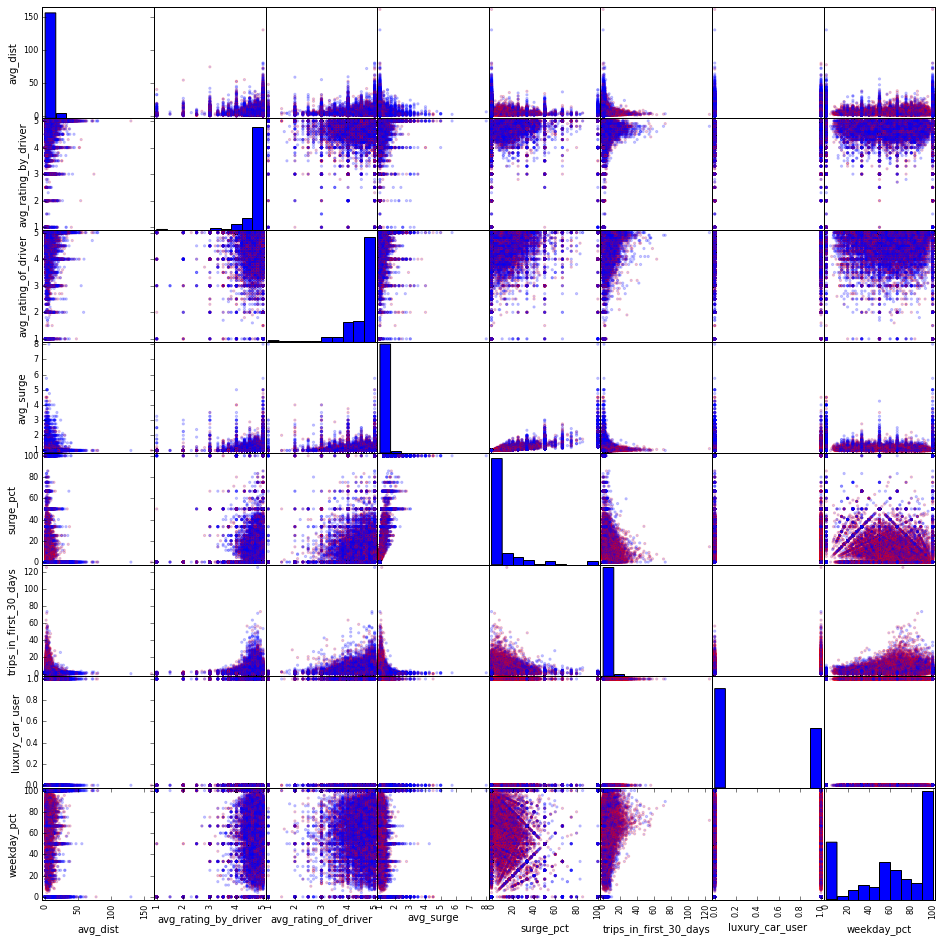

In [27]:
scatter_matrix(df[core_features], alpha=0.2, figsize=(16, 16), diagonal='hist', color=colors)

The scatter matrix does not show any feature which will clearly separate out active vs. inactive users. Some features do seem to help. Thus, we probably have a highly non-linear relationship and should consider a random forest or gradient boosted decision tree, which are ensemble versions of a decision tree. With a lot of feature engineering, we might be able to get comparable performance from logistic regression. SVM almost certainly will not work because there is no clear separation of postive and negative calsses.

There seems to be some observations where surge_pct = (+/-) weekday_pct. May merit further investigation or signal a data feed/entry problem.


### Missing data: EDA

The count field shows some columns have missing data. Let's look into this and figure out how to deal with it.

In [28]:
df.apply(lambda x: np.sum(pd.isnull(x)))

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                        0
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
is_active                    0
b_churned                    0
signup_year                  0
signup_month                 0
last_year                    0
last_month                   0
dtype: int64

So, ~16% of avg_rating_of_driver is missing, which means we probably should not drop this data. Would be nice to just do a simple t-test to see if distribution of features is different for rows with/without missing values. Here is a helper function:

In [31]:
def ttest_by(vals, by):
    '''Compute a t-test on a column based on an indicator for which sample the values are in.'''
    vals1 = vals[by]
    vals2 = vals[-by]
    
    return stats.ttest_ind(vals1, vals2)


In [32]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_of_driver))

Ttest_indResult(statistic=29.754284259108406, pvalue=7.407707064855626e-193)

In [33]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_by_driver))

Ttest_indResult(statistic=0.92179603168389357, pvalue=0.35663942563201456)

We can reject H0: of no difference only for case where avg_rating_by_driver is missing. Thus, avg_rating_by_driver is not missing at random. Can probably drop data when phone or avg_rating_by_driver are missing because they are so rare. We have a couple options for handling missing data: drop the rows if there are only a few or they are missing at random, impute the missing values, or bin the feature by quantiles (typically deciles) + a bin for missing.

In [34]:
df['b_no_rating_of_driver'] = pd.isnull(df.avg_rating_of_driver)

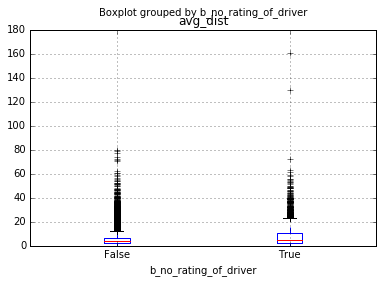

In [35]:
df.boxplot('avg_dist', by='b_no_rating_of_driver')

In [36]:
df2 = df[(pd.notnull(df.avg_rating_by_driver))]

In [37]:
df2.apply(lambda x: np.sum(pd.isnull(x)))

avg_dist                     0
avg_rating_by_driver         0
avg_rating_of_driver      8055
avg_surge                    0
city                         0
last_trip_date               0
phone                        0
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
is_active                    0
b_churned                    0
signup_year                  0
signup_month                 0
last_year                    0
last_month                   0
b_no_rating_of_driver        0
dtype: int64

In [38]:
pd.crosstab(df.b_churned, df.is_active) # Simple check

is_active,False,True
b_churned,,
False,0,18310
True,31690,0


In [39]:
pd.crosstab(df2.b_churned, df2.is_active) # Simple check

is_active,False,True
b_churned,,
False,0,18276
True,31523,0


We lose 77+34 observations which did not churn, so dropping these missing rows should be fine.


In [40]:
df3 = df[pd.notnull(df.avg_rating_of_driver)]

In [41]:
pd.crosstab(df3.b_churned, df3.is_active) # Simple check

is_active,False,True
b_churned,,
False,0,16742
True,25136,0


We may be able to drop observations which are missing avg_rating_of_driver

In [42]:
df.groupby('b_no_rating_of_driver').describe().T


b_no_rating_of_driver     False                                           \
                          count         mean        std     min      25%   
avg_dist                41878.0     5.465290   5.151833     0.0     2.42   
avg_rating_by_driver    41744.0     4.776648   0.404109     1.0     4.70   
avg_rating_of_driver    41878.0     4.601559   0.617338     1.0     4.30   
avg_surge               41878.0     1.074095   0.200861     1.0     1.00   
last_month              41878.0     4.200368   1.959421     1.0     2.00   
last_year               41878.0  2014.000000   0.000000  2014.0  2014.00   
signup_month            41878.0     1.000000   0.000000     1.0     1.00   
signup_year             41878.0  2014.000000   0.000000  2014.0  2014.00   
surge_pct               41878.0     8.908004  18.401140     0.0     0.00   
trips_in_first_30_days  41878.0     2.604972   4.055311     0.0     0.00   
weekday_pct             41878.0    61.289756  34.858046     0.0    37.50   

b_no_rating_of_driver                               True                \
                            50%      75%      max   count         mean   
avg_dist                   3.79     6.49    79.69  8122.0     7.506267   
avg_rating_by_driver       5.00     5.00     5.00  8055.0     4.785984   
avg_rating_of_driver       4.90     5.00     5.00     0.0          NaN   
avg_surge                  1.00     1.07     8.00  8122.0     1.078210   
last_month                 5.00     6.00     7.00  8122.0     3.227407   
last_year               2014.00  2014.00  2014.00  8122.0  2014.000000   
signup_month               1.00     1.00     1.00  8122.0     1.000000   
signup_year             2014.00  2014.00  2014.00  8122.0  2014.000000   
surge_pct                  0.00    11.10   100.00  8122.0     8.548067   
trips_in_first_30_days     1.00     3.00   125.00  8122.0     0.593327   
weekday_pct               66.70   100.00   100.00  8122.0    59.050948   

b_no_rating_of_driver                                                           
                              std     min      25%       50%      75%      max  
avg_dist                 7.758616     0.0     2.41     4.715    10.72   160.96  
avg_rating_by_driver     0.622122     1.0     5.00     5.000     5.00     5.00  
avg_rating_of_driver          NaN     NaN      NaN       NaN      NaN      NaN  
avg_surge                0.310306     1.0     1.00     1.000     1.00     5.00  
last_month               1.964936     1.0     1.00     3.000     5.00     7.00  
last_year                0.000000  2014.0  2014.00  2014.000  2014.00  2014.00  
signup_month             0.000000     1.0     1.00     1.000     1.00     1.00  
signup_year              0.000000  2014.0  2014.00  2014.000  2014.00  2014.00  
surge_pct               26.578461     0.0     0.00     0.000     0.00   100.00  
trips_in_first_30_days   0.606755     0.0     0.00     1.000     1.00     5.00  
weekday_pct             46.859739     0.0     0.00   100.000   100.00   100.00

This statistics make it clear that the two populations are different so ratings are almost certainly not missing at random.


In [43]:
df.groupby('is_active').describe().T

is_active                 False                                           \
                          count         mean        std     min      25%   
avg_dist                31690.0     6.188478   6.213027     0.0     2.32   
avg_rating_by_driver    31523.0     4.786876   0.503869     1.0     4.80   
avg_rating_of_driver    25136.0     4.607018   0.664816     1.0     4.40   
avg_surge               31690.0     1.075367   0.250219     1.0     1.00   
last_month              31690.0     2.893910   1.627276     1.0     1.00   
last_year               31690.0  2014.000000   0.000000  2014.0  2014.00   
signup_month            31690.0     1.000000   0.000000     1.0     1.00   
signup_year             31690.0  2014.000000   0.000000  2014.0  2014.00   
surge_pct               31690.0     8.688548  22.132211     0.0     0.00   
trips_in_first_30_days  31690.0     1.659167   2.661903     0.0     0.00   
weekday_pct             31690.0    60.181597  40.985698     0.0    16.70   

is_active                                            True                \
                            50%      75%      max    count         mean   
avg_dist                   4.03     7.77   129.89  18310.0     5.118977   
avg_rating_by_driver       5.00     5.00     5.00  18276.0     4.763121   
avg_rating_of_driver       5.00     5.00     5.00  16742.0     4.593364   
avg_surge                  1.00     1.00     8.00  18310.0     1.073720   
last_month                 3.00     5.00     6.00  18310.0     6.029929   
last_year               2014.00  2014.00  2014.00  18310.0  2014.000000   
signup_month               1.00     1.00     1.00  18310.0     1.000000   
signup_year             2014.00  2014.00  2014.00  18310.0  2014.000000   
surge_pct                  0.00     0.00   100.00  18310.0     9.128165   
trips_in_first_30_days     1.00     2.00    73.00  18310.0     3.349590   
weekday_pct               66.70   100.00   100.00  18310.0    62.214604   

is_active                                                                      
                              std     min      25%      50%      75%      max  
avg_dist                 4.627946     0.0     2.56     3.73     5.88   160.96  
avg_rating_by_driver     0.324566     1.0     4.70     4.80     5.00     5.00  
avg_rating_of_driver     0.538166     1.0     4.30     4.80     5.00     5.00  
avg_surge                0.163183     1.0     1.00     1.00     1.09     4.50  
last_month               0.170396     6.0     6.00     6.00     6.00     7.00  
last_year                0.000000  2014.0  2014.00  2014.00  2014.00  2014.00  
signup_month             0.000000     1.0     1.00     1.00     1.00     1.00  
signup_year              0.000000  2014.0  2014.00  2014.00  2014.00  2014.00  
surge_pct               15.489344     0.0     0.00     0.00    13.30   100.00  
trips_in_first_30_days   5.020615     0.0     0.00     2.00     4.00   125.00  
weekday_pct             29.068319     0.0    45.50    65.20    85.70   100.00

We see that summary statistics vary depending on activity status. Thus, we are hopeful that the variation in the data will help us build a model.

### Rating data

We need to take a closer look at the rating data because most users rate drivers 5. MBAs often worry about mean opinion score (MOS). How the app works can affect ratings. E.g., for Uber, if you rate a driver below 4, you must then explain why. Consequently, many people don't rate drivers below 4 even if they are horrible. Be mindful of the incentives which can affect human behavior.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f369b66ad90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3698fa75d0>], dtype=object)

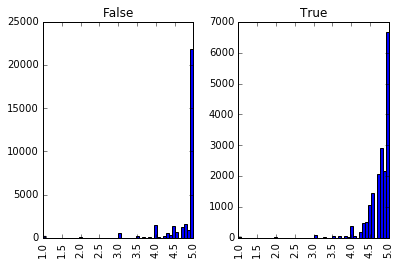

In [44]:
df.avg_rating_by_driver.hist(bins=50, histtype='bar', by=df.is_active, stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f369b2bf990>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f369b1d7850>], dtype=object)

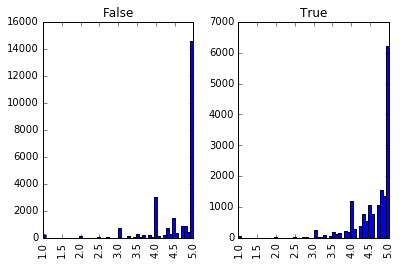

In [45]:
df.avg_rating_of_driver.hist(bins=50, histtype='bar', by=df.is_active, stacked=True)

Many users clearly only rate drivers 5 and, conversely, many drivers only rate users 5. Note the spike at 4 because many users don't want the hassle of explaining why they rated a driver below 4.

In [46]:
df['b_rating_5'] = df.avg_rating_of_driver == 5

In [47]:
pd.crosstab(df.b_rating_5, df.is_active, dropna=False, margins=True)

KeyError: 'Level None not found'

Note: 51% of active users always rate drivers 5 vs. 85% of inactive users. We will worry more about this during feature engineering

### Missing data: solution

We have two main options:

   1. Use df3 where we have dropped rows which are missing rating information.
   2. Quantize features with missing data, but use full data set, df. Add missing bin value for quantized features. Typically, use deciles.

Because a significant fraction of people only give out a rating of 5 and there are disincentives to give a rating below 4, we choose appropriate cuts below. If data was distributed more smoothly, we would cut by quantile. Note that the way we setup the cuts, the top bin contains only ratings whose average is 5: thus, we do not need the b_rating_5 field.


In [48]:
df['bin_avg_rating_by_driver'] = pd.cut(df.avg_rating_by_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                        include_lowest=True, right=True)
df['bin_avg_rating_of_driver'] = pd.cut(df.avg_rating_of_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                        include_lowest=True, right=True)

In [49]:
pd.crosstab(df.bin_avg_rating_by_driver, df.b_rating_5)

b_rating_5,False,True
bin_avg_rating_by_driver,,
"[0, 2.99]",232,116
"(2.99, 3.99]",753,468
"(3.99, 4.99]",13621,6101
"(4.99, 5]",14519,13989


In [50]:
pd.crosstab(df.bin_avg_rating_by_driver, df.is_active)

is_active,False,True
bin_avg_rating_by_driver,,
"[0, 2.99]",309,39
"(2.99, 3.99]",948,273
"(3.99, 4.99]",8428,11294
"(4.99, 5]",21838,6670


In [51]:
pd.crosstab(df.bin_avg_rating_of_driver, df.b_rating_5)

b_rating_5,False,True
bin_avg_rating_of_driver,,
"[0, 2.99]",701,0
"(2.99, 3.99]",3111,0
"(3.99, 4.99]",17295,0
"(4.99, 5]",0,20771


In [52]:
pd.crosstab(df.bin_avg_rating_of_driver, df.b_rating_5)

b_rating_5,False,True
bin_avg_rating_of_driver,,
"[0, 2.99]",701,0
"(2.99, 3.99]",3111,0
"(3.99, 4.99]",17295,0
"(4.99, 5]",0,20771


In [53]:
df.bin_avg_rating_by_driver.cat.add_categories('missing', inplace=True)
df.bin_avg_rating_of_driver.cat.add_categories('missing', inplace=True)


In [54]:
df.bin_avg_rating_by_driver.fillna('missing', inplace=True)
df.bin_avg_rating_of_driver.fillna('missing', inplace=True)

In [55]:
pd.crosstab(df.bin_avg_rating_by_driver, df.bin_avg_rating_of_driver)

bin_avg_rating_of_driver,"[0, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5]",missing
bin_avg_rating_by_driver,,,,,
"[0, 2.99]",23,25,39,116,145
"(2.99, 3.99]",52,125,319,468,257
"(3.99, 4.99]",236,1757,10721,6101,907
"(4.99, 5]",382,1196,6195,13989,6746
missing,8,8,21,97,67


Now these fields are binned with a level for missing. Convert to dummy variables.


In [56]:
df_dum_by = pd.get_dummies(df.bin_avg_rating_by_driver)
df_dum_by.apply(lambda x: x.value_counts())

,"[0, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5]",missing
0.0,49652,48779,30278,21492,49799
1.0,348,1221,19722,28508,201


In [59]:
df_dum_of = pd.get_dummies(df.bin_avg_rating_of_driver)
df_dum_of.apply(lambda x: x.value_counts())

,"[0, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5]",missing
0.0,49299,46889,32705,29229,41878
1.0,701,3111,17295,20771,8122


In [60]:
df_dum_of.columns = map(lambda x: 'bin_of_driver_' + str(x), df_dum_of.columns)

In [61]:
df_dum_phone = pd.get_dummies(df.phone)

In [62]:
df_dum_city = pd.get_dummies(df.city)


Assemble data into complete DataFrame

In [63]:
df_all = pd.concat([df.avg_dist, df_dum_phone, df_dum_city, df.ix[:, 
                    ['surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 
                     'weekday_pct', 'is_active']], df_dum_by, df_dum_of], axis=1)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
avg_dist                      50000 non-null float64
Android                       50000 non-null float64
iPhone                        50000 non-null float64
no_phone                      50000 non-null float64
Astapor                       50000 non-null float64
King's Landing                50000 non-null float64
Winterfell                    50000 non-null float64
surge_pct                     50000 non-null float64
trips_in_first_30_days        50000 non-null int64
luxury_car_user               50000 non-null bool
weekday_pct                   50000 non-null float64
is_active                     50000 non-null bool
[0, 2.99]                     50000 non-null float64
(2.99, 3.99]                  50000 non-null float64
(3.99, 4.99]                  50000 non-null float64
(4.99, 5]                     50000 non-null float64
missing                       50000 non-null float6

In [64]:
df_all.describe().T


,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
Android,50000.0,0.300440,0.458454,0.0,0.00,0.00,1.00,1.00
iPhone,50000.0,0.691640,0.461821,0.0,0.00,1.00,1.00,1.00
no_phone,50000.0,0.007920,0.088642,0.0,0.00,0.00,0.00,1.00
Astapor,50000.0,0.330680,0.470463,0.0,0.00,0.00,1.00,1.00
King's Landing,50000.0,0.202600,0.401941,0.0,0.00,0.00,0.00,1.00
Winterfell,50000.0,0.466720,0.498896,0.0,0.00,0.00,1.00,1.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


We have assembled a basic dataset. We may want to peform further feature engineering:

    Indicators for signup dates (ISO week, month, year)
    Interactions between features



### Modeling

Now we move to the modeling phase

### First model

### Code to plot ROC curve

In [65]:


def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)
    
    return tprs, fprs, thresholds.tolist()

def plot_roc(probs, y_true, title, xlabel, ylabel):
    # ROC
    tpr, fpr, thresholds = roc_curve(v_probs, y_test)

    plt.hold(True)
    plt.plot(fpr, tpr)

    # 45 degree line
    xx = np.linspace(0, 1.0, 20)
    plt.plot(xx, xx, color='red')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()



### Setup data with simple train/test split

In [66]:
v_features = df_all.columns
v_features = v_features.tolist()
v_features = v_features[:]
del v_features[v_features.index('is_active')]


In [67]:
X = df_all.ix[:, v_features]
y = df_all.is_active.astype('int')


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)


### First crappy model: logistic regression

In [69]:
lr = LogisticRegression(class_weight='auto')
lr.fit(X_train, y_train)


/home/neelima/anaconda2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
lr.score(X_test,y_test)

0.74819999999999998

In [71]:
v_probs = lr.predict_proba(X_test)[:, 1]

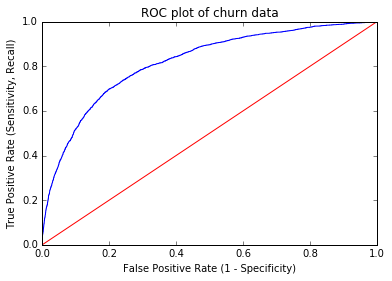

In [74]:
plot_roc(v_probs, y_test, "ROC plot of churn data", 
         "False Positive Rate (1 - Specificity)", "True Positive Rate (Sensitivity, Recall)")

In [75]:
skm.roc_auc_score(y_test, lr.predict(X_test))

0.7468694104315784

Not a great AUC...


In [76]:
pd.crosstab(y_test, lr.predict(X_test))

col_0,0,1
is_active,,
0,4771,1575
1,943,2711


In [77]:
def plot_confusion_matrix(model, X_test, y_true):
    '''Code stolen brazenly from sklearn example.'''
    cm = confusion_matrix(y_true, model.predict(X_test))

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


[[4771 1575]
 [ 943 2711]]


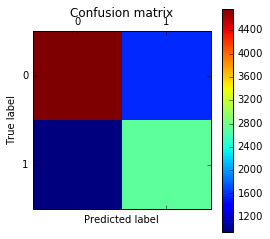

In [78]:
plot_confusion_matrix(lr, X_test, y_test)

Simple model is not very good and would be much worse without class_weight='auto'. Rerun without class_weight='auto'.

### A slightly better crappy model: gradient boosting classification trees



The non-linear nature of the problem makes decision trees appealing. But, it makes sense to use an ensemble model (random forest, gradient boosting) to get the best performance.

In [79]:
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=8, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [80]:
gbc.score(X_test,y_test)

0.7863

In [81]:
pd.crosstab(y_test, gbc.predict(X_test))

col_0,0,1
is_active,,
0,5441,905
1,1232,2422




This looks a bit better.


In [82]:
skm.roc_auc_score(y_test, gbc.predict(X_test))

0.76011286561782665



This is not great, but not horrible...


[[5441  905]
 [1232 2422]]


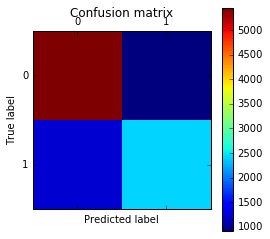

In [83]:
plot_confusion_matrix(gbc, X_test, y_test)

In [84]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='auto')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
rfc.score(X_test, y_test)

0.75219999999999998

In [86]:
pd.crosstab(y_test, rfc.predict(X_test))

col_0,0,1
is_active,,
0,5143,1203
1,1275,2379


In [87]:
pd.crosstab(y_train, rfc.predict(X_train))

col_0,0,1
is_active,,
0,25285,59
1,71,14585


In [88]:
skm.roc_auc_score(y_test, rfc.predict(X_test))

0.73074954576198914

[[5143 1203]
 [1275 2379]]


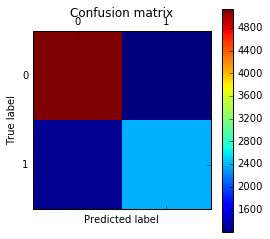

In [89]:
plot_confusion_matrix(rfc, X_test, y_test)



The model appears to be a bit worse than gradient boosting.


### Refine model

Now we try several things:

    Scale data
    Use grid search to find the best tuning of each model
    Compare different classification models
    Explore feature engineering
    Tune with profit curve based on costs of different classification errors


In [90]:
X[['avg_dist', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']].describe()

,avg_dist,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,8.849536,2.278200,60.926084
std,5.707357,19.958811,3.792684,37.081503
min,0.000000,0.000000,0.000000,0.000000
25%,2.420000,0.000000,0.000000,33.300000
50%,3.880000,0.000000,1.000000,66.700000
75%,6.940000,8.600000,3.000000,100.000000
max,160.960000,100.000000,125.000000,100.000000


In [91]:
X.avg_dist = scale(X.avg_dist)
X.surge_pct = scale(X.surge_pct)
X.trips_in_first_30_days = scale(X.trips_in_first_30_days.astype('float'))
X.weekday_pct = scale(X.weekday_pct)

In [92]:
X[['avg_dist', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']].describe()

,avg_dist,surge_pct,trips_in_first_30_days,weekday_pct
count,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04
mean,-2.558398e-17,8.276602e-16,-8.546253e-16,1.350848e-15
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-1.015686e+00,-4.433944e-01,-6.006888e-01,-1.643048e+00
25%,-5.916680e-01,-4.433944e-01,-6.006888e-01,-7.450173e-01
50%,-3.358553e-01,-4.433944e-01,-3.370206e-01,1.557103e-01
75%,2.003002e-01,-1.250267e-02,1.903157e-01,1.053741e+00
max,2.718679e+01,4.566974e+00,3.235783e+01,1.053741e+00


In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
avg_dist                      50000 non-null float64
Android                       50000 non-null float64
iPhone                        50000 non-null float64
no_phone                      50000 non-null float64
Astapor                       50000 non-null float64
King's Landing                50000 non-null float64
Winterfell                    50000 non-null float64
surge_pct                     50000 non-null float64
trips_in_first_30_days        50000 non-null float64
luxury_car_user               50000 non-null bool
weekday_pct                   50000 non-null float64
[0, 2.99]                     50000 non-null float64
(2.99, 3.99]                  50000 non-null float64
(3.99, 4.99]                  50000 non-null float64
(4.99, 5]                     50000 non-null float64
missing                       50000 non-null float64
bin_of_driver_[0, 2.99]       50000 non-null f

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

### Refine gradient boosting model via grid search¶


In [119]:
gbc_grid = {
    'learning_rate': [1.0, 0.5, 0.01],
    'max_depth': [1, 3, 8],
    'min_samples_leaf': [3],
    'max_features': ['sqrt', 'log2', None ],
    'n_estimators': [500, 1000],
    'subsample': [0.5, 0.75, 1.0]
}

# The above grid takes a long time to run.  These are the best settings:
gbc_grid = {'learning_rate': [0.01],
 'max_depth': [8],
 'max_features': [None],
 'min_samples_leaf': [3],
 'n_estimators': [1000],
 'subsample': [0.5]
}

# Refined grid
gbc_grid = {
    'learning_rate': [0.75, 0.01, 0.005],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2', None ],
    'n_estimators': [500, 1000],
    'subsample': [0.25, 0.5]
}

In [120]:
gbc_grid_cv = GridSearchCV(GradientBoostingClassifier(), gbc_grid, n_jobs=-1)

In [ ]:
gbc_grid_cv.fit(X_train, y_train)

In [ ]:
best_model = gbc_grid_cv.best_estimator_

In [ ]:
best_params = gbc_grid_cv.best_params_
best_params

In [ ]:
gbc_grid_cv.best_score_

In [ ]:
skm.roc_auc_score(y_test, best_model.predict(X_test))

In [101]:
def plot_importance(clf, X, max_features=10):
    '''Plot feature importance'''
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

In [ ]:
plot_importance(best_model, X_train, max_features=16)

Note which features are the most important: avg_dist, weekday_pct, surge_pct, and trips_in_first_30_days. These features are much more important than other features. Also, dropping missing ratings would be a mistake, because the missing bin for avg_rating_of_driver is the third most important rating bin.

In [ ]:
def plot_loss(clf, params):
    '''Plot training deviance.  Stolen from sklearn documentation'''    
    # compute test set deviance
    test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    plt.title('Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel(clf.loss)


In [ ]:
plot_loss(best_model, best_params)

In [ ]:
plot_confusion_matrix(best_model, X_test, y_test)



Given enough time, it could be useful to check partial dependence plots, especially to understand feature interactions. In addition, we could further refine feature engineering, such as binning.

In conclusion, we might want to further tune learning_rate, n_estimators, max_depth, and min_samples_leaf because their optimal values are on the edge of the grid.


### Refine random forest model via grid search¶


In [102]:
rf_grid = {
    'max_depth': [4, 8, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True], # Mandatory with oob_score=True
    'n_estimators': [50, 100, 200, 400],
    'random_state': [67],
    'oob_score': [True],
    'n_jobs': [-1]
    }

In [103]:
rf_grid_cv = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')


In [106]:
rf_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 449 tasks       | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 799 tasks       | elapsed: 86.0min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 133.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 400], 'min_samples_split': [1, 2, 4], 'oob_score': [True], 'random_state': [67], 'n_jobs': [-1], 'max_features': ['sqrt', 'log2', None], 'bootstrap': [True], 'max_depth': [4, 8, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [107]:
rf_grid_cv.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 400,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 67}

In [108]:
rf_grid_cv.best_score_

0.84887791250428724

In [109]:
best_model = rf_grid_cv.best_estimator_

In [110]:
best_model.oob_score_

0.78425

In [111]:
skm.roc_auc_score(y_test, best_model.predict(X_test))

0.76129471245047731

[[5456  890]
 [1232 2422]]


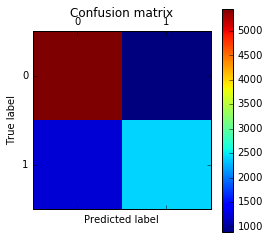

In [112]:
plot_confusion_matrix(best_model, X_test, y_test)



AUC and confusion matrix suggest that the gradient boosting model is better than random forest.


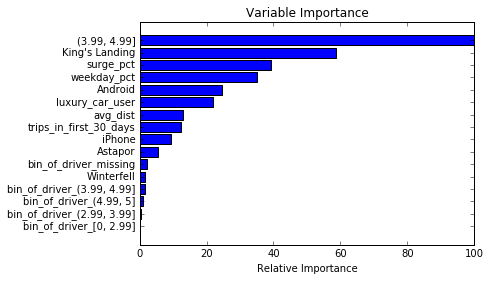

In [113]:
plot_importance(best_model, X_train, max_features=16)

In [114]:
m_oob = best_model.oob_decision_function_

In [116]:
# This code is hacked from sklearn documentation.

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 400
error_rate = []

In [117]:
best_clf = RandomForestClassifier(bootstrap=True,
     max_depth=None, max_features='sqrt', min_samples_leaf=4,
     min_samples_split=1, n_estimators=400, n_jobs=-1,
     oob_score=True, random_state=67)

for ix in range(min_estimators, max_estimators + 1, 10):
    clf = clone(best_clf)
    clf.set_params(n_estimators=ix)
    clf.fit(X_train, y_train)

    # Record the OOB error for each `n_estimators=ix` setting.
    oob_error = 1 - clf.oob_score_
    error_rate.append((ix, oob_error))

/home/neelima/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


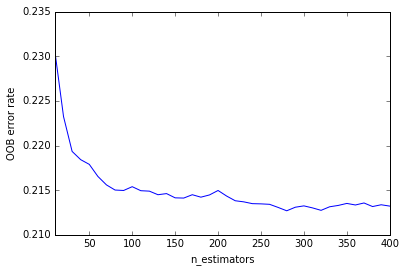

In [118]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
m_oob = np.array(error_rate)
plt.plot(m_oob[:,0], m_oob[:,1])
plt.xlim(min_estimators, max_estimators)
#plt.ylim(0, m_oob[:,1].max())
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")

Looks like OOB error rate has stabilizd around 250 or so estimators.

### Profit curves

Should refine using data about costs of misclassification. Should talk to product manager to get relevant economic costs and benefits for retention.

### Report: conclusions & recommendations

Now, present results and recommendations.

Analysis should focus on the marginal consumer (the one indifferent between using the service and not) because these are the consumers we can most easily affect with incentives.
